### imports

In [2]:
!pip install tensorflow
!pip install gensim

In [3]:
import tensorflow as tf
from tensorflow import keras

from gensim.models import Word2Vec
from gensim.models import LsiModel
import gensim

import numpy as np
import matplotlib.pyplot as plt

from scipy.cluster.hierarchy import dendrogram, linkage, fcluster

### prepare dataset

In [5]:
import json
import contractions

def pad_sequence(dataset):
    max_len = len(max(dataset, key=len))
    print("max length of MWO:", max_len)
    for i in range(len(dataset)):
        count = 0
        while len(dataset[i]) < max_len:
            dataset[i].append(dataset[i][count])
            count+=1
    return dataset

def add_inherent_functions(row):
    for e in row["entities"]:
        tokens = row["tokens"]
        entity_type = e["type"].split("/")
        if entity_type[0] == "PhysicalObject":
            if len(entity_type) > 1 and entity_type[1] not in ["Substance", "Organism"]:
                if entity_type[1][:-6].lower() not in tokens:
                    tokens.append(entity_type[1][:-6].lower())
                # tokens.append(entity_type[1][-6:].lower())
    return tokens

    # BROKEN CODE
    # physical_object_indices = []
    # 
    # for e in row["entities"]:
    #     new_list = row["tokens"]
    #     entity_type = e["type"].split("/")
    #     if entity_type[0] == "PhysicalObject":
    #         if len(entity_type) > 1 and entity_type[1] not in ["Substance", "Organism"]:
    #             new_string = " ".join(new_list)
    #             if e["end"] == len(row["tokens"]):
    #                 replace_index = new_string.find(" ".join(row["tokens"][e["start"]:]))
    #                 new_string = new_string.replace(" ".join(row["tokens"][e["start"]:]))
    #             else:
    #                 replace_index = new_string.find(" ".join(row["tokens"][e["start"]:e["end"]]))
    #                 new_string = new_string.replace(" ".join(row["tokens"][e["start"]:e["end"]]), "")
    #             new_string = new_string[replace_index:]
    #             new_list = new_string.split()
    #             physical_object_indices.append((e["start"], e["end"], entity_type[1]))
    # for i in physical_object_indices:
    #     if i[1] == len(row["tokens"]):
    #         row["tokens"].append(i[2])
        

def clean_tokens(tokens):
    stopwords =["<num>", "<id>", "-"]
    tokens = [i for i in tokens if i not in stopwords]
    tokens = contractions.fix(" ".join(tokens)).split()
    return tokens

def prepare_dataset(filename):
    f = open(filename, "r")
    # returns JSON object as a dictionary
    data = json.load(f)

    dataset = []

    for datum in data:
        keep_indices = []
        for entity in datum["entities"]:
            if entity["type"].split("/")[0] not in ["PhysicalObject", "Activity"]:
                start = entity["start"]
                end = entity["end"]
                for i in range(start, end):
                    keep_indices.append(i)

        tokens = []
        for i in sorted(set(keep_indices)):
            tokens.append(datum["tokens"][i])
        
        tokens = clean_tokens(tokens)
        if tokens:
            dataset.append(" ".join(tokens))
    # dataset = pad_sequence(dataset)
    return dataset

def full_dataset(filename):
    f = open(filename, "r")
    # returns JSON object as a dictionary
    data = json.load(f)

    d = []

    for datum in data:
        types = [e["type"].split("/")[0] for e in datum["entities"]]
        if "State" in types or "Process" in types or "Property" in types:
            tokens = clean_tokens(datum["tokens"])
            # d.append(" ".join(tokens))
            d.append(tokens)
    # d = pad_sequence(dataset)
    return d

def full_dataset_append_inherent_functions(filename):
    f = open(filename, "r")
    # returns JSON object as a dictionary
    data = json.load(f)

    d = []

    for datum in data:
        types = [e["type"].split("/")[0] for e in datum["entities"]]
        if "State" in types or "Process" in types or "Property" in types:
            tokens = add_inherent_functions(datum)
            tokens = clean_tokens(tokens)
            d.append(" ".join(tokens))
    return d

## CNN

In [6]:
dataset = full_dataset("../data/gold_release.json")
print(dataset)
pad_sequence(dataset)
print(dataset)

[['air', 'conditioner', 'thermostat', 'not', 'working'], ['air', 'conditioner', 'thermostat', 'unserviceable'], ['air', 'conditioner', 'unserviceable'], ['air', 'conditioner', 'unserviceable', 'when', 'stationary'], ['air', 'conditioner', 'warm'], ['air', 'filters', 'plugged'], ['air', 'horn', 'disconnected'], ['air', 'horn', 'does', 'not', 'work'], ['air', 'horn', 'fault'], ['air', 'horn', 'not', 'working'], ['air', 'horn', 'not', 'working', 'compressor', 'awaiting'], ['air', 'horn', 'stuck', 'on'], ['air', 'horn', 'unserviceable'], ['air', 'horn', 'working', 'intermittently'], ['air', 'leak'], ['air', 'leak', 'near', 'side', 'of', 'door'], ['air', 'leaking', 'from', 'line', 'outside'], ['airhorn', 'not', 'working'], ['alarm', 'on', 'VIMS', 'does', 'not', 'work'], ['all', 'dash', 'lights', 'on'], ['alternator', 'drive', 'leaking'], ['alternator', 'failed'], ['alternator', 'not', 'charging'], ['alternator', 'overcharge', 'fault'], ['alternator', 'overcharged'], ['analyse', 'failed', 'd

In [7]:
# Word2Vec embeddings as input
w2vmodel = gensim.models.Word2Vec(dataset, min_count=1, vector_size=100,
                                window=5, sg=1)
w2v_embeddings = []
for sentence in dataset:
    row = []
    for word in sentence:
        row.append(w2vmodel.wv[word])
    w2v_embeddings.append(row)
w2v_embeddings = np.array(w2v_embeddings)

In [8]:
print(w2v_embeddings.shape)
shape = w2v_embeddings.shape
w2v_embeddings=w2v_embeddings.reshape(shape[0], shape[1], shape[2], 1)
print(w2v_embeddings.shape)


(560, 11, 100)
(560, 11, 100, 1)


In [9]:
# LSI embeddings as output
dictionary = gensim.corpora.Dictionary(dataset)
doc_term_matrix = [dictionary.doc2bow(doc) for doc in dataset]
lsamodel = LsiModel(doc_term_matrix, num_topics=10, id2word = dictionary)  # train model
concepts = list(lsamodel[doc_term_matrix])
lsa_embeddings=[]
for i in concepts:
    row = []
    for j in i:
        row.append(j[1])
    lsa_embeddings.append(row)
lsa_embeddings = np.array(lsa_embeddings)

In [10]:
print(lsa_embeddings.shape)
print(lsa_embeddings)

(560, 10)
[[-2.70686084  1.6978534  -2.18957016 ... -0.68222745 -0.06844941
  -1.02615219]
 [-3.04402751  1.93546204 -2.12914795 ...  0.30090208  0.65149789
   0.88340347]
 [-4.03755163  2.56913644 -2.7687367  ...  0.51918248  0.98516583
   1.35540807]
 ...
 [-0.5169451   0.42023121 -0.1974771  ...  0.54646124  1.03719138
   0.7696685 ]
 [-0.50280595 -0.36636697  0.30757612 ... -1.41630226  0.9649631
   0.01659632]
 [-0.52838962  0.40366666 -0.02698924 ...  1.1237736   1.35205689
   1.92840472]]


In [31]:
dr = 10
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(16, (2, 2), activation='relu', padding="same", input_shape=(11,100,1)),
    tf.keras.layers.MaxPool2D(pool_size=2),
    tf.keras.layers.Conv2D(8, (2, 2), activation='relu', padding="same"),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=dr, activation="tanh"),
    tf.keras.layers.Dense(units=10, activation="tanh")
])


In [32]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 11, 100, 16)    │            80 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 5, 50, 16)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 5, 50, 8)       │           520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 2000)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 10)             │        20,010 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 10)             │           110 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,720 (80.94 KB)

 Trainable params: 20,720 (80.94 KB)

 Non-trainable params: 0 (0.00 B)

In [33]:
optimizer = tf.keras.optimizers.SGD(learning_rate=0.001)

opt = tf.keras.optimizers.Adam(learning_rate=0.001)

model.compile(optimizer=opt,
              loss=tf.keras.losses.MeanSquaredLogarithmicError("sum_over_batch_size"),
              metrics=['accuracy'])

history = model.fit(w2v_embeddings, lsa_embeddings, epochs=100)


Epoch 1/100


18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.2173 - loss: 0.1031
Epoch 2/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.2526 - loss: 0.0826
Epoch 3/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.2561 - loss: 0.0854
Epoch 4/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.2356 - loss: 0.0846
Epoch 5/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.2205 - loss: 0.0879
Epoch 6/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.2445 - loss: 0.0799
Epoch 7/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.2283 - loss: 0.0816
Epoch 8/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.2254 - loss: 0.0848
Epoch 9/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.2558 - loss: 0.0815
Epoch 10/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.2537 - loss: 0.0789
Epoch 11/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.2817 - loss: 0.0831
Epoch 12/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.3033 - lo

[0.21964286267757416, 0.23928570747375488, 0.23928570747375488, 0.23928570747375488, 0.23928570747375488, 0.24285714328289032, 0.24285714328289032, 0.24285714328289032, 0.24821428954601288, 0.2767857015132904, 0.2785714268684387, 0.2964285612106323, 0.35357141494750977, 0.3375000059604645, 0.3375000059604645, 0.3553571403026581, 0.375, 0.4214285612106323, 0.40535715222358704, 0.4267857074737549, 0.43214285373687744, 0.40535715222358704, 0.4017857015132904, 0.4178571403026581, 0.4482142925262451, 0.4464285671710968, 0.4553571343421936, 0.4303571283817291, 0.4000000059604645, 0.46785715222358704, 0.4839285612106323, 0.4303571283817291, 0.4660714268684387, 0.4660714268684387, 0.49464285373687744, 0.47678571939468384, 0.4732142984867096, 0.45178571343421936, 0.4892857074737549, 0.47678571939468384, 0.4714285731315613, 0.47678571939468384, 0.4839285612106323, 0.5071428418159485, 0.4803571403026581, 0.4892857074737549, 0.47678571939468384, 0.4910714328289032, 0.48571428656578064, 0.503571450

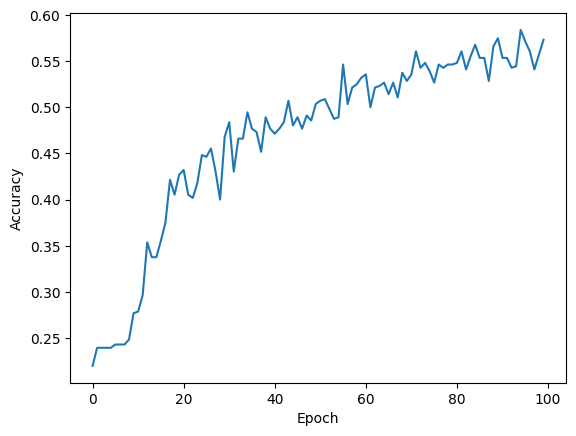

In [34]:
acc = history.history['accuracy']
print(acc)
plt.plot(acc)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
# plt.ylim([0, 1])
# plt.legend(loc='lower right')
plt.show()


In [35]:
model2 = tf.keras.Sequential([
    tf.keras.layers.Conv2D(16, (2, 2), activation='relu', padding="same", input_shape=(11,100,1)),
    tf.keras.layers.MaxPool2D(pool_size=2),
    tf.keras.layers.Conv2D(8, (2, 2), activation='relu', padding="same"),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=dr, activation="tanh"),
])

model2.layers[0].set_weights(model.layers[0].get_weights())
model2.layers[2].set_weights(model.layers[2].get_weights())
model2.layers[4].set_weights(model.layers[4].get_weights())



In [36]:
cluster_embeddings = model2.predict(w2v_embeddings)
print(cluster_embeddings.shape)

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
(560, 10)


In [37]:
dataset_not_padded = full_dataset("../data/gold_release.json")
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=15, random_state=42, n_init=100).fit(cluster_embeddings)
labels = kmeans.labels_
for i in range(15):
    print("Cluster ", i)
    for j in range(len(labels)):
        if labels[j] == i:
            print(dataset_not_padded[j])

Cluster  0
['change', 'out', 'blown', 'o-ring', 'on', 'steering', 'pump']
['change', 'out', 'blown', 'position', 'tyre']
['change', 'out', 'blown', 'steering', 'hose']
['change', 'out', 'broken', 'prelube', 'bracket']
['change', 'out', 'broken', 'stabilizer', 'bar']
['change', 'out', 'cracked', 'pipe', 'on', 'valve', 'bank']
['change', 'out', 'front', 'upper', 'window', 'cracked']
['change', 'out', 'leak', 'slew', 'motor', 'hose']
['change', 'out', 'leaking', 'HMU', 'on', 'next']
['change', 'out', 'leaking', 'fan', 'hoses']
['change', 'out', 'leaking', 'heater', 'taps']
['change', 'out', 'leaking', 'hydraulic', 'hose']
['change', 'out', 'leaking', 'implement', 'pump']
['change', 'out', 'leaking', 'relay', 'valve']
['change', 'out', 'leaking', 'steering', 'hose']
['change', 'out', 'left', 'hand', 'steering', 'cylinder', 'leaking']
['change', 'out', 'position', 'and', 'tyre', 'worn', 'out']
['change', 'out', 'position', 'tyre', 'sensor', 'not', 'reading']
['change', 'out', 'position', 't

## Hierachical Clustering

### Average clustering

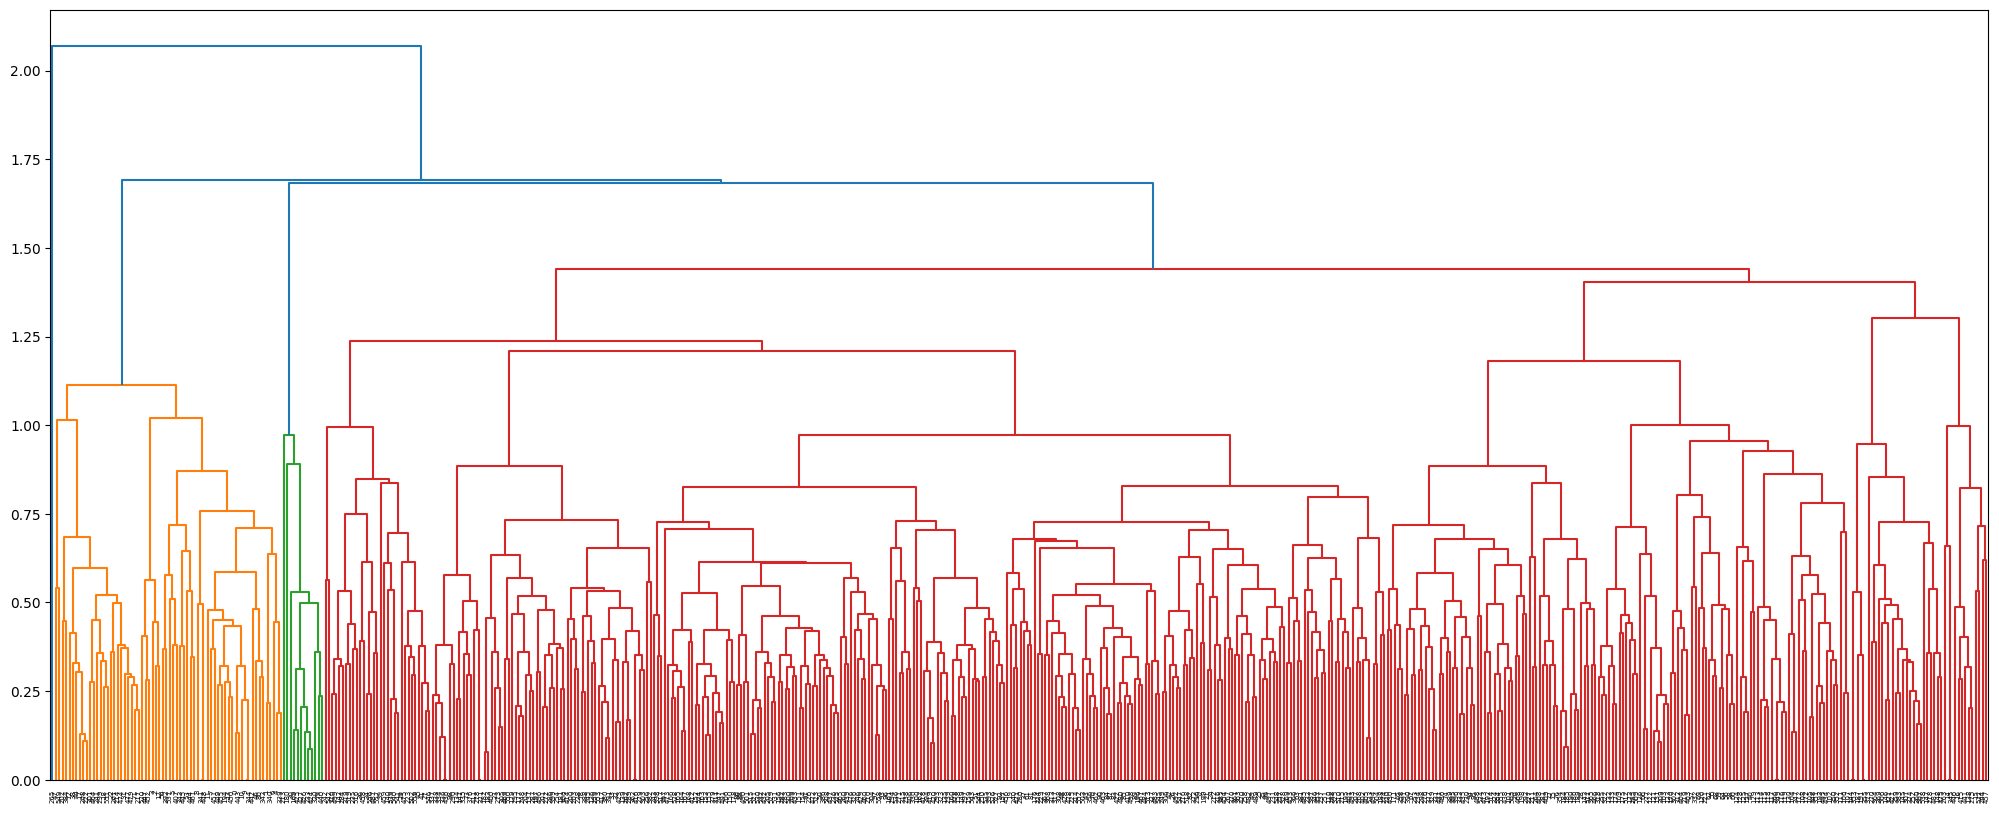

In [38]:
linkage_data = linkage(cluster_embeddings, method='average')
fig = plt.figure(figsize=(25, 10))
dn = dendrogram(linkage_data)
plt.show()

In [42]:
k=10
cluster_labels = fcluster(linkage_data, k, criterion='maxclust')
for i in range(1,k+1):
    print("Cluster",i,":")
    cluster_words = {}
    for j in range(len(cluster_labels)):
        if cluster_labels[j]==i:
            print(" ".join(dataset_not_padded[j]))
            for word in dataset_not_padded[j]:
                if word in cluster_words:
                    cluster_words[word]+=1
                else:
                    cluster_words[word]=1
    print("Top words:")
    sorted_cluster_words = sorted(cluster_words, key=cluster_words.get, reverse=True)
    for j in range(min(len(sorted_cluster_words), 5)):
        print(sorted_cluster_words[j])
    print()

Cluster 1 :
air conditioner thermostat not working
air conditioner thermostat unserviceable
air conditioner unserviceable
air conditioner unserviceable when stationary
air conditioner warm
air filters plugged
air horn disconnected
air horn does not work
air horn fault
air horn not working
air horn not working compressor awaiting
air horn stuck on
air horn unserviceable
air horn working intermittently
airhorn not working
alarm on VIMS does not work
alternator not charging
auto-spray feature not working
backup alarm not working
beacon not working
bearing on air conditioner compressor unserviceable
bearings are shot
blown air conditioner hose
blown air conditioner hose to radiator
boarding gate latch not working
boarding ladder not working
broken air conditioner guard
dragline air conditioner units need cleaning
electrical faults
speedometer not working
front revolving light not working
machine will not start
crane not working
system pump pressure gauge not working
mechanical PTO not mesh

### ward clustering

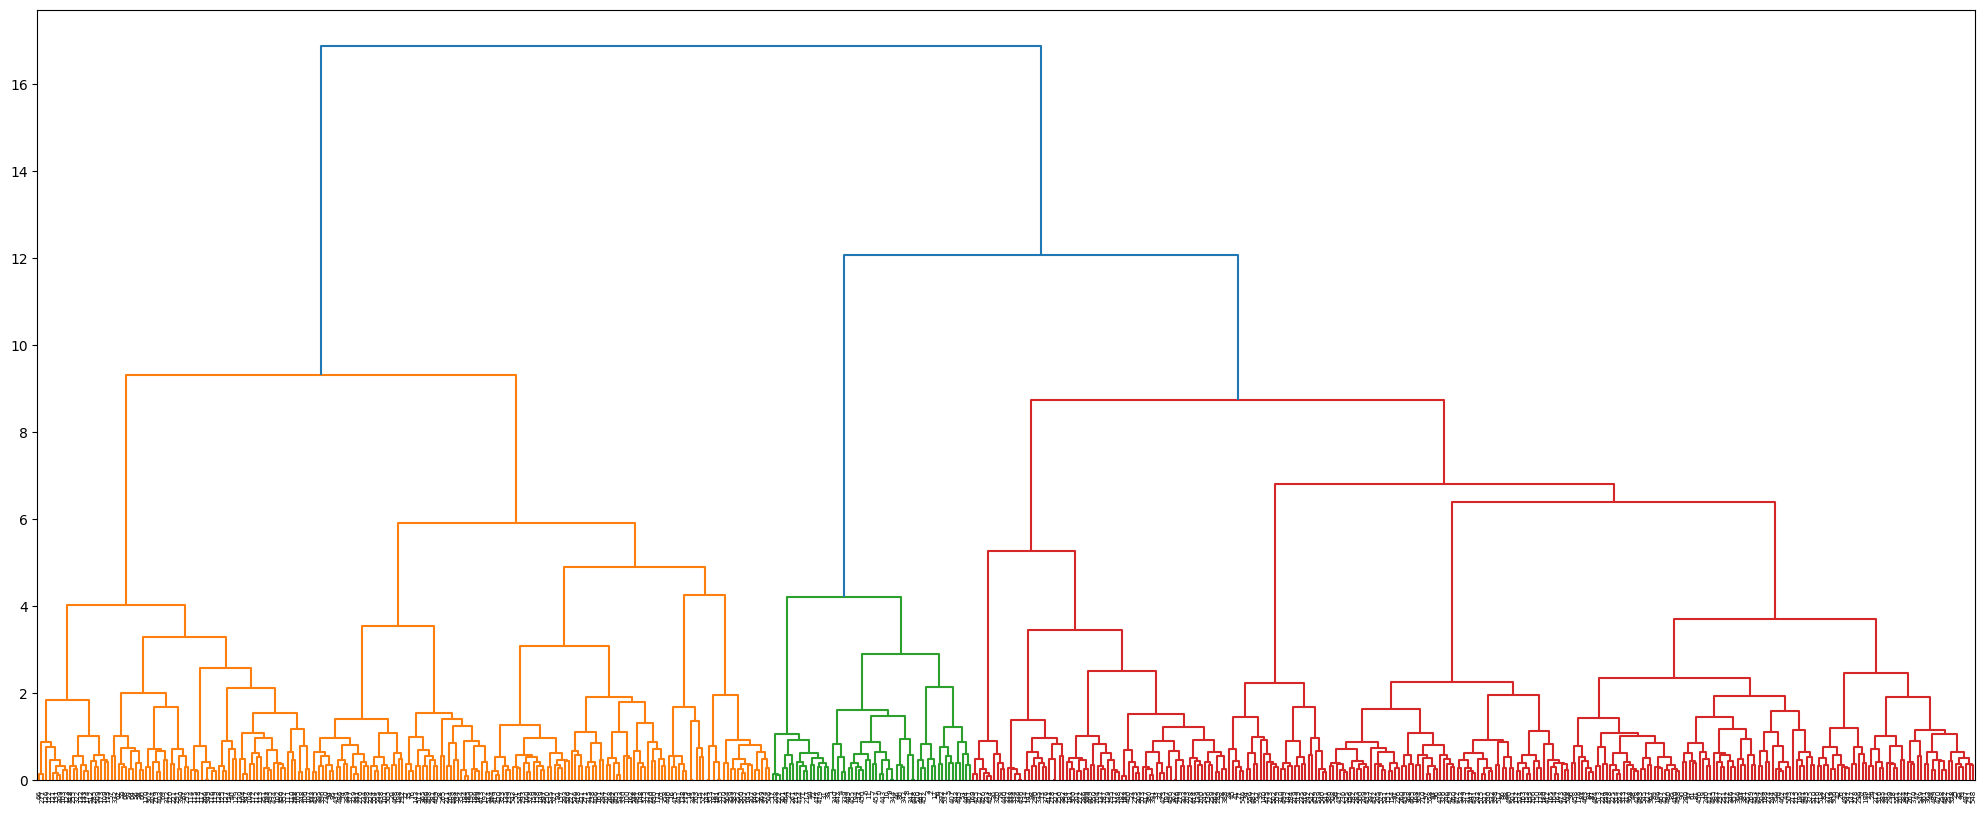

In [43]:
linkage_data = linkage(cluster_embeddings, method='ward')
fig = plt.figure(figsize=(25, 10))
dn = dendrogram(linkage_data)
plt.show()

In [46]:
k=8
cluster_labels = fcluster(linkage_data, k, criterion='maxclust')
for i in range(1,k+1):
    print("Cluster",i,":")
    cluster_words = {}
    for j in range(len(cluster_labels)):
        if cluster_labels[j]==i:
            print(" ".join(dataset_not_padded[j]))
            for word in dataset_not_padded[j]:
                if word in cluster_words:
                    cluster_words[word]+=1
                else:
                    cluster_words[word]=1
    print("Top words:")
    sorted_cluster_words = sorted(cluster_words, key=cluster_words.get, reverse=True)
    for j in range(min(len(sorted_cluster_words), 5)):
        print(sorted_cluster_words[j])
    print()

Cluster 1 :
batteries out of service
blown brake hose
blown crowd cylinder hose
blown extension line from position
blown hose in hitch
blown hose on boom
blown lift cylinder o-ring
blown o-ring off steering hose
blown o-ring on steering hose
blown position tyre
blown right hand bucket cylinder hose
blown steering hose
blown steering pump hose
change out blown o-ring on steering pump
change out blown position tyre
change out blown steering hose
change out broken bolt on brake pump
change out broken prelube bracket
change out broken stabilizer bar
change out cracked pipe on valve bank
change out cracked position adaptor and tooth
change out exhaust clamp broken on left hand side [t |]
change out front upper window cracked
change out leak slew motor hose
change out leaking HMU on next
change out leaking fan hoses
change out leaking heater taps
change out leaking hydraulic hose
change out leaking implement pump
change out leaking relay valve
change out leaking steering hose
change out left

### centroid clustering

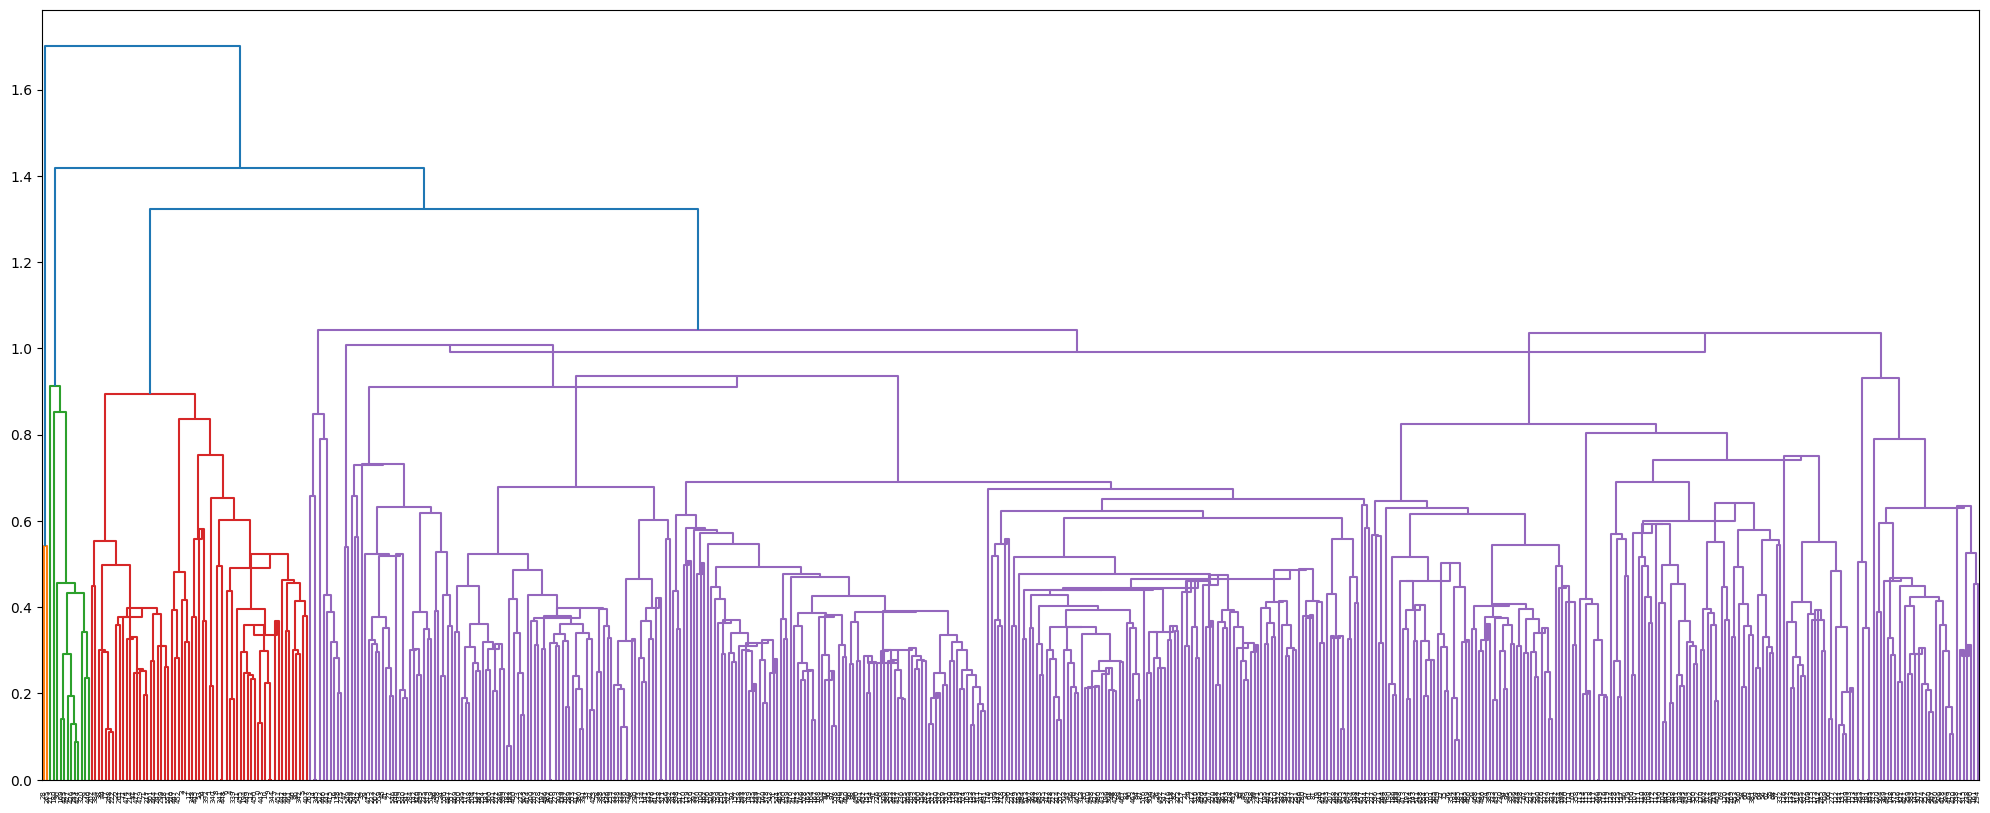

In [47]:
linkage_data = linkage(cluster_embeddings, method='centroid')
fig = plt.figure(figsize=(25, 10))
dn = dendrogram(linkage_data)
plt.show()

In [48]:
k=4
cluster_labels = fcluster(linkage_data, k, criterion='maxclust')
for i in range(1,k+1):
    print("Cluster",i,":")
    cluster_words = {}
    for j in range(len(cluster_labels)):
        if cluster_labels[j]==i:
            print(" ".join(dataset_not_padded[j]))
            for word in dataset_not_padded[j]:
                if word in cluster_words:
                    cluster_words[word]+=1
                else:
                    cluster_words[word]=1
    print("Top words:")
    sorted_cluster_words = sorted(cluster_words, key=cluster_words.get, reverse=True)
    for j in range(min(len(sorted_cluster_words), 5)):
        print(sorted_cluster_words[j])
    print()

Cluster 1 :
auto-greaser leaking oil
coolant leaking
Top words:
leaking
auto-greaser
oil
coolant

Cluster 2 :
auto-lube error PO
brake temperature error
crankcase error
diagnose and repair torque converter temperature error
position brake temperature error
volt supply error
diagnose VIMS error
V supply error
injector error
v supply error
v supply error issue
aftercooler temperature error
Top words:
error
temperature
supply
brake
diagnose

Cluster 3 :
air conditioner thermostat not working
air conditioner thermostat unserviceable
air conditioner unserviceable
air conditioner unserviceable when stationary
air conditioner warm
air filters plugged
air horn disconnected
air horn does not work
air horn fault
air horn not working
air horn not working compressor awaiting
air horn stuck on
air horn unserviceable
air horn working intermittently
airhorn not working
alarm on VIMS does not work
alternator not charging
auto-spray feature not working
backup alarm not working
beacon not working
bearin